## Accessing ESA WorldCover 2020 classification data with the Planetary Computer STAC API

The European Space Agency (ESA) [WorldCover](https://esa-worldcover.org/en) product is a global land cover map for the year 2020 produced at 10 meter resolution based on the combination of [Sentinel-1](https://sentinel.esa.int/web/sentinel/missions/sentinel-1) radar data and [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) imagery. The discrete classification map provides 11 classes and is defined using the Land Cover Classification System (LCCS) developed by the United Nations (UN) Food and Agriculture Organization (FAO).

This notebook demonstrates the use of the Planetary Computer STAC API to query for a portion of ESA WorldCover data that includes Mount Elgon near the border of Uganda and Kenya.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
- The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
- To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `pc.settings.set_subscription_key(<YOUR API Key>)`.

In [1]:
import pystac_client
import planetary_computer
import rasterio
from rasterio import windows
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

### Define the area of interest and search the collection

Let's define a bounding box around Mount Elgon, which sits on the border of Uganda and Kenya.

In [2]:
bbox_of_interest = [33.984, 0.788, 34.902, 1.533]

Use [pystac-client](https://github.com/stac-utils/pystac-client) to perform the search over the ESA WorldCover collection.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace    
)

search = catalog.search(
    collections=["esa-worldcover"],
    bbox=bbox_of_interest,
)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


Our search returned one item, a 3x3 degree tile of classification data. Each Item contains a single "map" Asset with a URL to the location of the Asset data on [Azure Blob Storage](https://azure.microsoft.com/en-us/services/storage/blobs/). 

In [4]:
asset_href = items[0].assets["map"].href
print(asset_href.split("?")[0])

https://ai4edataeuwest.blob.core.windows.net/esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N00E033_Map.tif


### Render our area of interest

Here we use [rasterio](https://rasterio.readthedocs.io/en/latest/) to download the data and matplotlib to display an image of our area of interest.

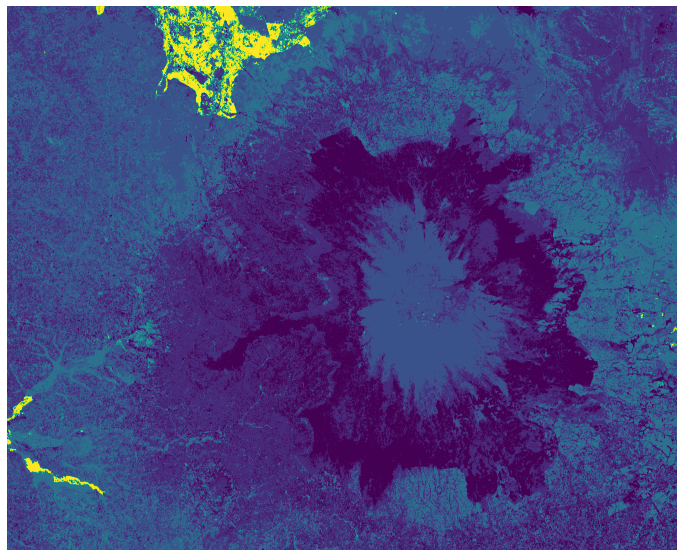

In [6]:
with rasterio.open(asset_href) as src:
    aoi_window = windows.from_bounds(transform=src.transform, *bbox_of_interest)
    raster_data = src.read(1, window=aoi_window)

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_axis_off()
ax.imshow(raster_data);

This looks interesting, but let's use the classification colors as defined in the [product user manual](https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf). The classification colors are also defined in a colormap contained in the source GeoTIFF image. We'll extract the colormap from the GeoTIFF image and apply it to the plot. 

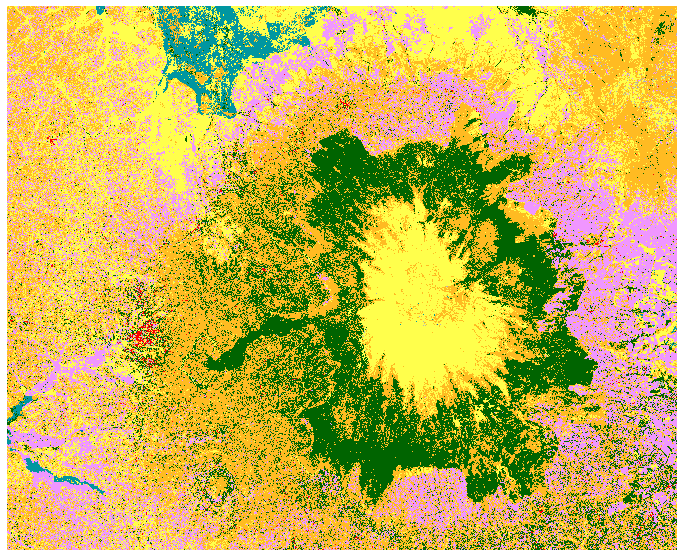

In [7]:
with rasterio.open(asset_href) as src:
    colormap_def = src.colormap(1)
    colormap = [np.array(colormap_def[i]) / 255 for i in range(len(colormap_def))]

cmap = ListedColormap(colormap)
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_axis_off()
ax.imshow(
    raster_data,
    cmap=cmap,
    vmin=0,
    vmax=(len(colormap_def) - 1),
    interpolation="nearest",
);

Rendering notes:
1. The `vmin` and `vmax` values are set to match the number of classes defined in the colormap in the source GeoTIFF image. Even though there are only 11 classes defined in the ESA WorldCover [Product User Manual](https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf), the GeoTIFF colormap is padded to produce 256 class values and corresponding colors. The color black is used for all padded values.
2. The `interpolation` value is set to `nearest` to avoid black artifacts that result from interpolated pixel values (the image is interpolated for display). When an interpolated value falls within a padded area of the colormap, it is displayed as black. We use the `nearest` interpolation method since it does not produce new pixel values that will fall within the padded areas of the colormap.